In [36]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [37]:
from pathlib import Path
import pandas as pd

from src.pipeline.pipeline_builder import PipelineBuilder

LOG_PATH = Path("../data/raw/csv/kaggle/Registro_de_Incidentes.csv")
assert LOG_PATH.exists(), f"Arquivo de log não encontrado: {LOG_PATH}"
LOG_PATH

PosixPath('../data/raw/csv/kaggle/Registro_de_Incidentes.csv')

In [38]:
df_events_incidents = pd.read_csv(LOG_PATH, sep=";", parse_dates=["Timestamp"])

df_events_incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242901 entries, 0 to 242900
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Case ID                242901 non-null  object        
 1   Variant                242901 non-null  object        
 2   Priority               242901 non-null  object        
 3   Reporter               242901 non-null  object        
 4   Timestamp              242901 non-null  datetime64[ns]
 5   Event                  242901 non-null  object        
 6   Issue Type             242901 non-null  object        
 7   Resolver               146405 non-null  object        
 8   Report Channel         242901 non-null  object        
 9   Short Description      242901 non-null  object        
 10  Customer Satisfaction  242901 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 20.4+ MB


/var/folders/qy/v482m2215v59dlznrv8yyrp80000gn/T/ipykernel_39272/2280142455.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_events_incidents = pd.read_csv(LOG_PATH, sep=";", parse_dates=["Timestamp"])


In [39]:
df_events_incidents.head(10)

,Case ID,Variant,Priority,Reporter,Timestamp,Event,Issue Type,Resolver,Report Channel,Short Description,Customer Satisfaction
0,INC0001,Variant 4,Medium,Alice,2023-11-17 11:17:00,Ticket created,Performance Issue,NaN,Website,Application crash,3
1,INC0001,Variant 4,Medium,Alice,2023-11-17 13:30:00,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3
2,INC0001,Variant 4,Medium,Alice,2023-11-17 14:06:00,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3
3,INC0001,Variant 4,Medium,Alice,2023-11-17 16:52:00,Level 1 escalates to level 2 support,Performance Issue,Michael,Website,Application crash,3
4,INC0001,Variant 4,Medium,Alice,2023-11-17 18:07:00,WIP - level 2 support,Performance Issue,Emma,Website,Application crash,3
5,INC0001,Variant 4,Medium,Alice,2023-11-17 20:10:00,Ticket solved by level 2 support,Performance Issue,Sarah,Website,Application crash,3
6,INC0001,Variant 4,Medium,Alice,2023-11-17 21:28:00,Ticket closed,Performance Issue,NaN,Website,Application crash,3
7,INC0002,Variant 3,High,Charlie,2023-08-15 07:08:00,Ticket created,Performance Issue,NaN,App,Data loss issue,3
8,INC0002,Variant 3,High,Charlie,2023-08-15 08:29:00,Ticket assigned to level 1 support,Performance Issue,Sam,App,Data loss issue,3
9,INC0002,Variant 3,High,Charlie,2023-08-15 08:39:00,WIP - level 1 support,Performance Issue,Sam,App,Data loss issue,3


In [40]:
df_events_incidents.describe()

,Timestamp,Customer Satisfaction
count,242901,242901.000000
mean,2023-07-01 18:31:09.225734400,3.233828
min,2023-01-01 00:07:00,1.000000
25%,2023-04-01 07:23:00,3.000000
50%,2023-07-01 10:22:00,3.000000
75%,2023-09-30 19:23:00,4.000000
max,2024-01-02 07:44:00,5.000000
std,NaN,1.161075


In [41]:
# Prepara o log Kaggle em schema canônico do pipeline
RAW_LOG_PATH = LOG_PATH
TARGET_COL = "customer_satisfaction"

df_raw = pd.read_csv(RAW_LOG_PATH, sep=";", parse_dates=["Timestamp"], dayfirst=True)

rename_map = {
    "Case ID": "case_id",
    "Event": "activity",
    "Timestamp": "timestamp",
    "Resolver": "resource",
    "Customer Satisfaction": TARGET_COL,
}
df_events = df_raw.rename(columns=rename_map)

# garante ordenação temporal por caso
df_events = df_events.sort_values(["case_id", "timestamp"]).reset_index(drop=True)
df_events.head()

,case_id,Variant,Priority,Reporter,timestamp,activity,Issue Type,resource,Report Channel,Short Description,customer_satisfaction
0,INC0001,Variant 4,Medium,Alice,2023-11-17 11:17:00,Ticket created,Performance Issue,NaN,Website,Application crash,3
1,INC0001,Variant 4,Medium,Alice,2023-11-17 13:30:00,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3
2,INC0001,Variant 4,Medium,Alice,2023-11-17 14:06:00,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3
3,INC0001,Variant 4,Medium,Alice,2023-11-17 16:52:00,Level 1 escalates to level 2 support,Performance Issue,Michael,Website,Application crash,3
4,INC0001,Variant 4,Medium,Alice,2023-11-17 18:07:00,WIP - level 2 support,Performance Issue,Emma,Website,Application crash,3


In [42]:
# Define builder do alvo: satisfação alta (> 4) por caso
def build_high_satisfaction_target(features, target_name="high_customer_satisfaction"):
    target = (features[TARGET_COL] > 4).astype(int)
    target.name = target_name
    return target

[2025-12-09 12:19:58,956] [PipelineBuilder] [INFO] Carregando log de eventos...
[2025-12-09 12:19:59,098] [PipelineBuilder] [INFO] Construindo features em nível de caso...
[2025-12-09 12:19:59,385] [PipelineBuilder] [INFO] Realizando split estratificado...
[2025-12-09 12:19:59,395] [PipelineBuilder] [INFO] Construindo preprocessor...
[2025-12-09 12:19:59,396] [PipelineBuilder] [INFO] Transformando dados...
[2025-12-09 12:19:59,607] [PipelineBuilder] [INFO] Treinando modelo final: LightGBMModel...


[LightGBM] [Info] Number of positive: 2393, number of negative: 16559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 18952, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126266 -> initscore=-1.934382
[LightGBM] [Info] Start training from score -1.934382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[2025-12-09 12:20:00,000] [PipelineBuilder] [INFO] Avaliando em validação...
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


AUC-ROC: 0.5913154716501399

Classification report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      5520
           1       0.00      0.00      0.00       798

    accuracy                           0.87      6318
   macro avg       0.44      0.50      0.47      6318
weighted avg       0.76      0.87      0.81      6318


Confusion matrix:
 [[5520    0]
 [ 798    0]]


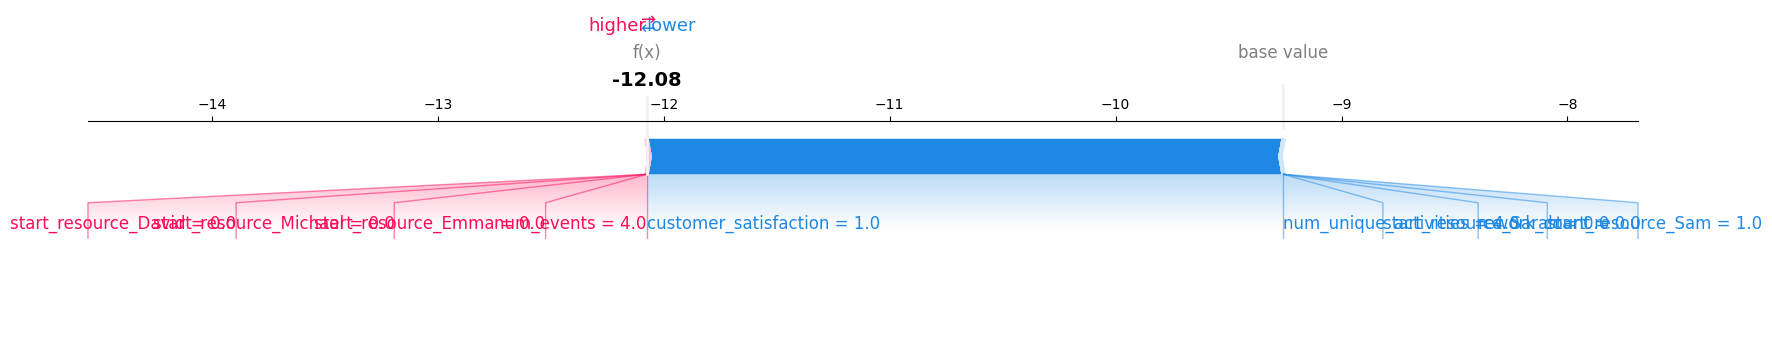

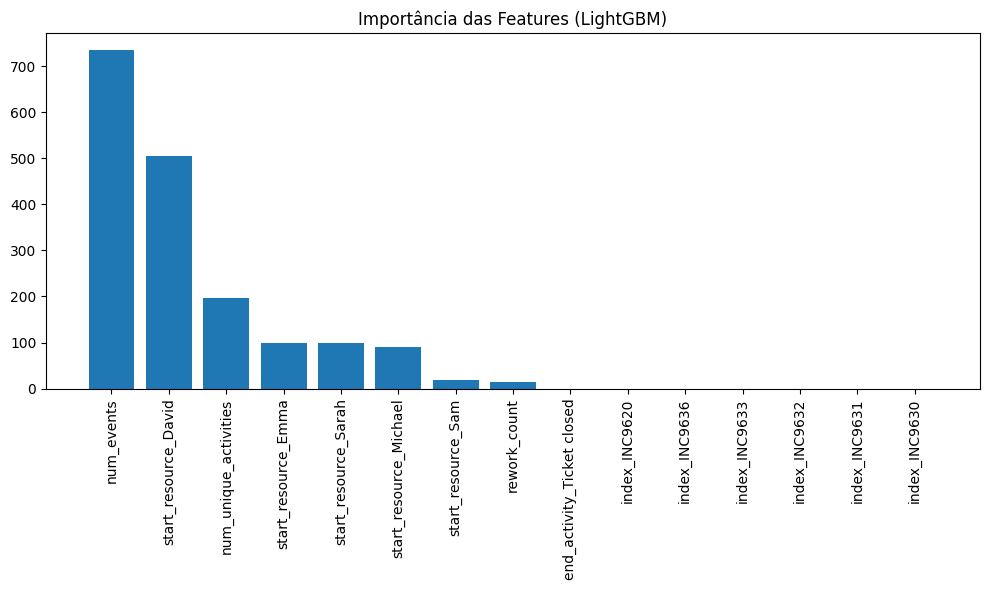

[2025-12-09 12:20:00,236] [PipelineBuilder] [INFO] Computando SHAP values...
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
[2025-12-09 12:20:00,328] [PipelineBuilder] [INFO] Plotando SHAP summary...


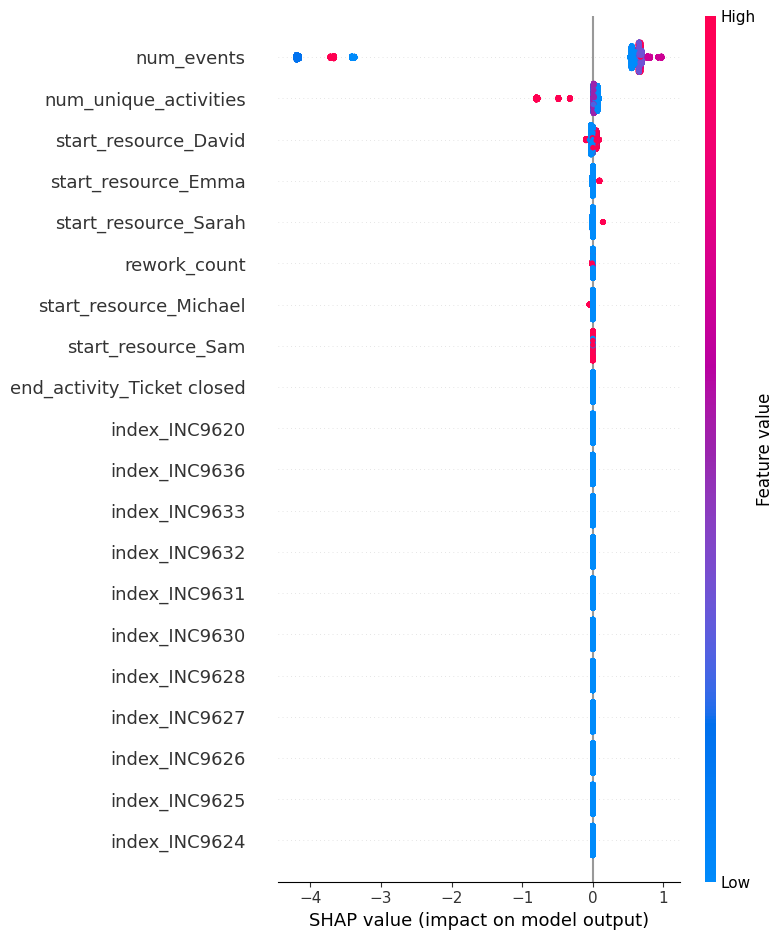

ValueError: Shape of passed values is (6318, 1), indices imply (6318, 56217)

In [43]:
from importlib import reload
import src.preprocessing.build_features as build_features_mod
import src.pipeline.pipeline_builder as pipeline_builder
from src.models.lightgbm_model import LightGBMModel

# garanta que build_features e PipelineBuilder estão na versão atual
build_features_mod = reload(build_features_mod)
pipeline_builder = reload(pipeline_builder)
PipelineBuilder = pipeline_builder.PipelineBuilder

interim_log_path = Path("../data/interim/kaggle_incidents_prepared.csv")
interim_log_path.parent.mkdir(parents=True, exist_ok=True)
df_events.to_csv(interim_log_path, index=False)

# toggles de inclusão de features case-level
FEATURE_FLAGS = dict(
    include_throughput_feature=False,
    include_num_events=True,
    include_num_unique_activities=True,
    include_rework_count=True,
    include_start_activity=True,
    include_end_activity=True,
    include_start_resource=True,
    include_mean_cost=True,
    include_extra_numeric_cols=True,
    drop_feature_cols=[TARGET_COL],  # evita leakage da variável-alvo
)

pipeline = PipelineBuilder(
    model_class=LightGBMModel,
    optimize_hyperparams=False,
)

model, artifacts, splits = pipeline.run_from_event_log(
    str(interim_log_path),
    sla_hours=72,
    target_builders=[build_high_satisfaction_target],
    include_default_target=False,
    target_col="high_customer_satisfaction",
    case_id_col="case_id",
    activity_col="activity",
    timestamp_col="timestamp",
    resource_col="resource",
    extra_numeric_cols=[TARGET_COL],
    **FEATURE_FLAGS,
)

In [ ]:
# Resumo dos splits e distribuição do alvo
summary = pd.DataFrame(
    {
        "split": ["train", "val", "test"],
        "rows": [len(splits.X_train), len(splits.X_val), len(splits.X_test)],
        "positivos": [
            int(splits.y_train.sum()),
            int(splits.y_val.sum()),
            int(splits.y_test.sum()),
        ],
    }
)
summary["taxa_positivos"] = (summary["positivos"] / summary["rows"]).round(3)
summary

print("Features numéricas:", artifacts.numeric_features)
print("Features categóricas:", artifacts.categorical_features)

Features numéricas: ['throughput_hours', 'num_events', 'num_unique_activities', 'rework_count', 'customer_satisfaction']
Features categóricas: ['start_activity', 'end_activity', 'start_resource']
